Loading data from: c:\Users\Oliver\OneDrive\Dokumenter\GitHub\Statistic_Evaluation_Project\HR_data.csv
Cleaned columns: ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC', 'Round', 'Phase', 'Puzzler', 'Frustrated', 'Cohort']


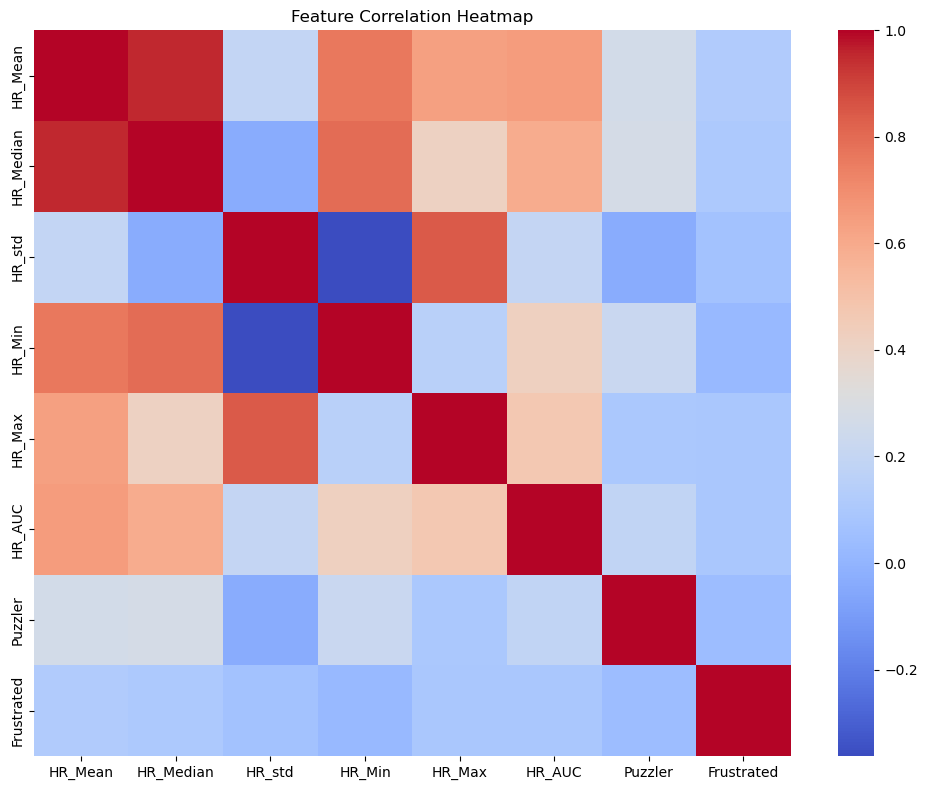

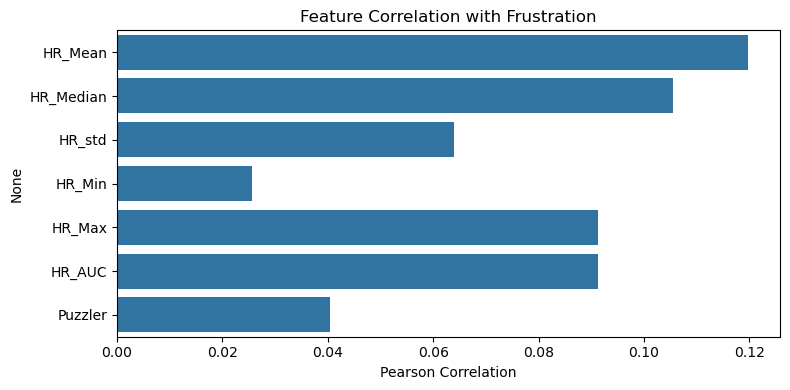

Features selected by correlation: []
Fallback: using all numeric features: ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max', 'HR_AUC', 'Puzzler']
Features selected by RFE: ['HR_Mean', 'HR_Median', 'HR_std', 'HR_Min', 'HR_Max']
Ridge Regression: MAE = 1.599 ± 0.152
Random Forest: MAE = 1.728 ± 0.109
SVR: MAE = 1.540 ± 0.125


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

# --- Step 1: Load and clean data ---
file_path = os.path.join(os.getcwd(), "HR_data.csv")
print(f"Loading data from: {file_path}")

df = pd.read_csv(file_path, index_col=0)

# Drop unnamed columns and the participant ID column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
if 'Individual' in df.columns:
    df = df.drop(columns='Individual')
print("Cleaned columns:", df.columns.tolist())

# --- Step 1.1: Correlation heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm', cbar=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

# --- Step 2: Feature correlation with Frustrated ---
corr = df.corr(numeric_only=True)
frustration_corr = corr['Frustrated'].drop('Frustrated')

plt.figure(figsize=(8, 4))
sns.barplot(x=frustration_corr.values, y=frustration_corr.index)
plt.title("Feature Correlation with Frustration")
plt.xlabel("Pearson Correlation")
plt.tight_layout()
plt.savefig("feature_vs_frustration_correlation.png")
plt.show()

# Select features with abs(correlation) > 0.2
selected_features = frustration_corr[frustration_corr.abs() > 0.2].index.tolist()
print("Features selected by correlation:", selected_features)

if len(selected_features) == 0:
    selected_features = df.select_dtypes(include=np.number).columns.drop('Frustrated').tolist()
    print("Fallback: using all numeric features:", selected_features)

X_selected = df[selected_features]
y = df['Frustrated']

# --- Step 3: RFE for further selection ---
ridge = Ridge(alpha=1.0)
n_features = max(1, min(5, len(selected_features)))
rfe = RFE(estimator=ridge, n_features_to_select=n_features)
rfe.fit(X_selected, y)

X_final = X_selected.loc[:, rfe.support_]
print("Features selected by RFE:", X_final.columns.tolist())

# --- Step 4: Models ---
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# --- Step 5: Cross-validation ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Step 6: Evaluate models ---
for name, model in models.items():
    pipeline = make_pipeline(StandardScaler(), model)
    scores = cross_val_score(pipeline, X_final, y, scoring='neg_mean_absolute_error', cv=kf)
    print(f"{name}: MAE = {-np.mean(scores):.3f} ± {np.std(scores):.3f}")



Evaluating Ridge Regression
 Fold 1: MAE=1.778, RMSE=1.942
 Fold 2: MAE=1.407, RMSE=1.638
 Fold 3: MAE=1.770, RMSE=2.193
 Fold 4: MAE=1.632, RMSE=2.057
 Fold 5: MAE=1.438, RMSE=1.848
Average MAE: 1.605 ± 0.158
Average RMSE: 1.935 ± 0.188


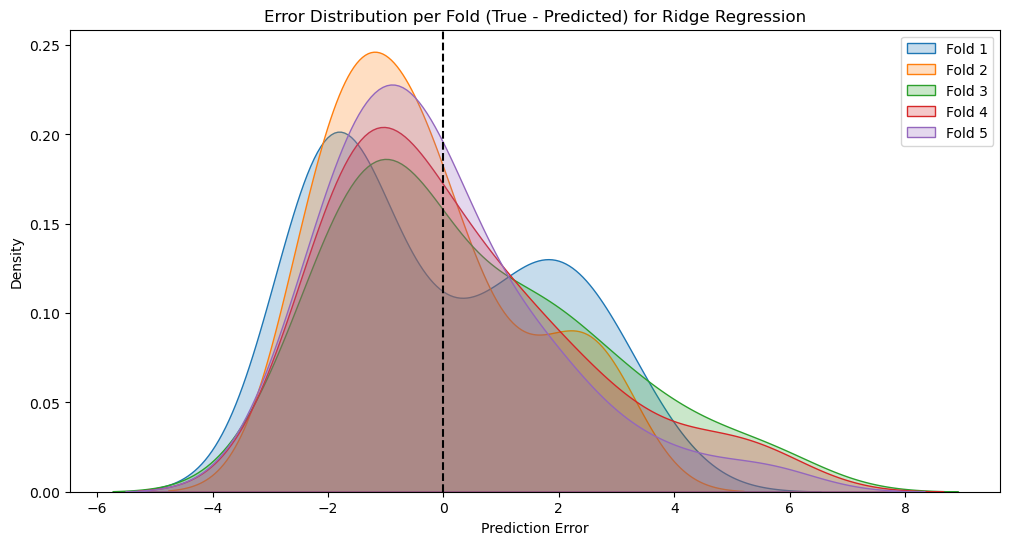

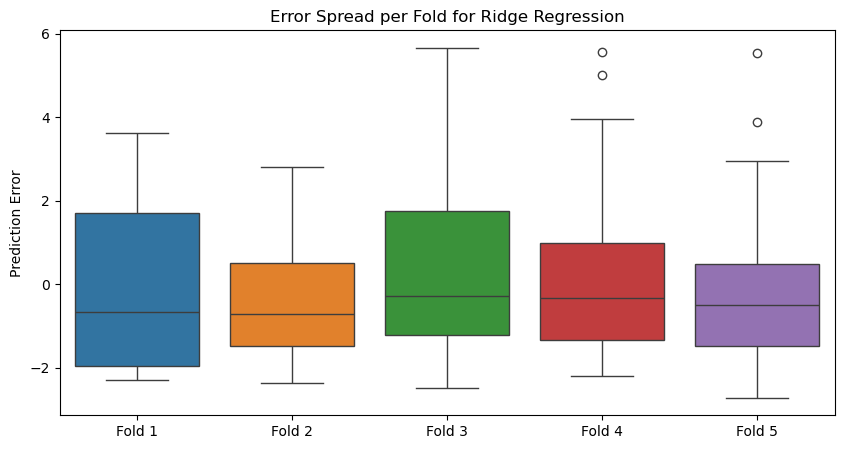


Top 10 samples with highest absolute errors in Ridge Regression Fold 3:
       True      Pred     Error
Index                          
163       8  2.331921  5.668079
64        7  1.711083  5.288917
73        6  2.117794  3.882206
100       6  2.375096  3.624904
115       5  1.892861  3.107139
94        5  2.051975  2.948025
131       0  2.486800 -2.486800
128       0  2.233984 -2.233984
117       0  2.198950 -2.198950
120       0  2.069685 -2.069685

Evaluating Random Forest
 Fold 1: MAE=1.653, RMSE=1.819
 Fold 2: MAE=1.586, RMSE=1.820
 Fold 3: MAE=1.681, RMSE=2.201
 Fold 4: MAE=1.679, RMSE=2.105
 Fold 5: MAE=1.681, RMSE=2.076
Average MAE: 1.656 ± 0.037
Average RMSE: 2.004 ± 0.156


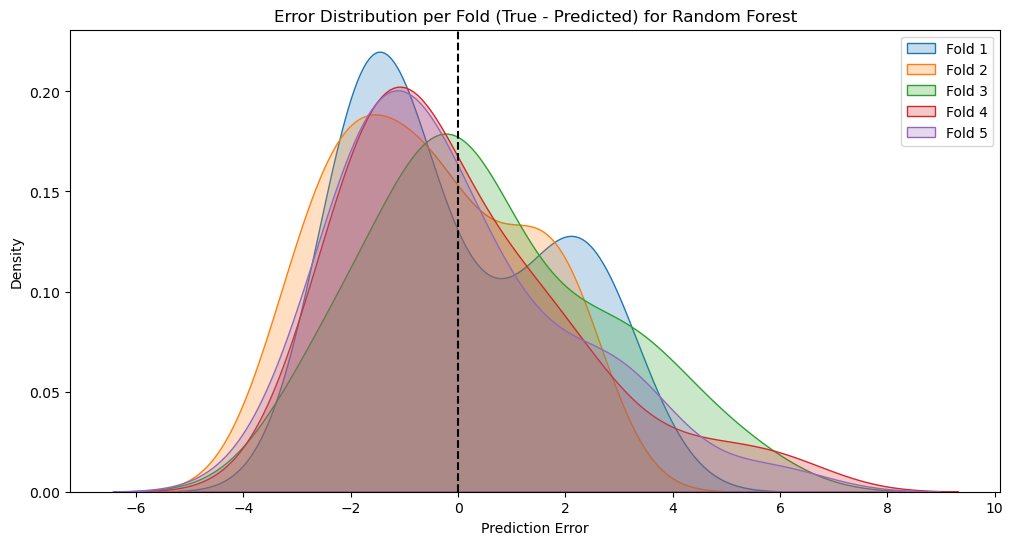

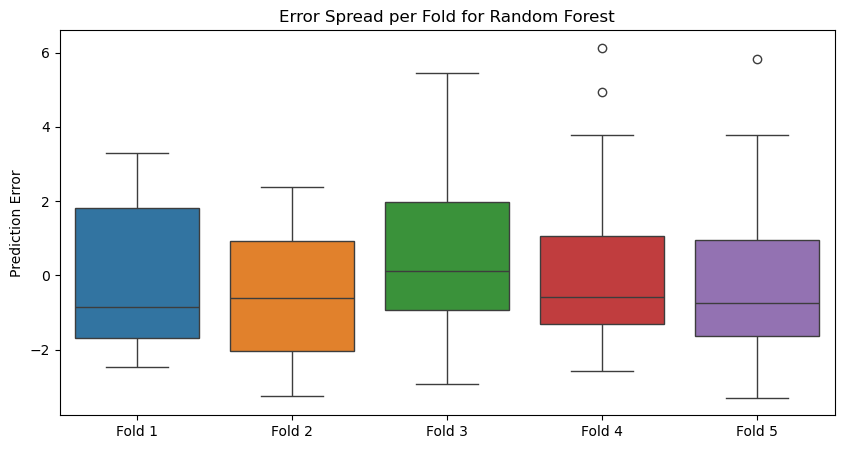


Top 10 samples with highest absolute errors in Random Forest Fold 3:
       True   Pred  Error
Index                    
64        7  1.560  5.440
163       8  3.210  4.790
73        6  2.300  3.700
100       6  2.470  3.530
115       5  1.550  3.450
166       4  0.895  3.105
94        5  2.040  2.960
128       0  2.930 -2.930
23        1  3.740 -2.740
28        1  3.550 -2.550


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Step 1: Load and clean data ---
file_path = os.path.join(os.getcwd(), "HR_data.csv")
df = pd.read_csv(file_path, index_col=0)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# --- Step 2: Define input features and target ---
selected_features = ['HR_Mean', 'HR_Median', 'HR_Max', 'HR_AUC', 'HR_std']
X = df[selected_features]
y = df['Frustrated']

# --- Step 3: Setup models ---
models = {
    'Ridge Regression': make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# --- Step 4: KFold setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}")
    mae_per_fold = []
    rmse_per_fold = []
    errors_per_fold = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        errors = y_test - y_pred
        errors_per_fold.append(errors.reset_index(drop=True))  # Reset index to avoid issues

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        mae_per_fold.append(mae)
        rmse_per_fold.append(rmse)

        print(f" Fold {fold + 1}: MAE={mae:.3f}, RMSE={rmse:.3f}")

    print(f"Average MAE: {np.mean(mae_per_fold):.3f} ± {np.std(mae_per_fold):.3f}")
    print(f"Average RMSE: {np.mean(rmse_per_fold):.3f} ± {np.std(rmse_per_fold):.3f}")

    # --- Plot error distributions ---
    plt.figure(figsize=(12, 6))
    for i, errors in enumerate(errors_per_fold):
        sns.kdeplot(errors, label=f"Fold {i + 1}", fill=True)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Error Distribution per Fold (True - Predicted) for {model_name}")
    plt.xlabel("Prediction Error")
    plt.ylabel("Density")
    plt.legend()
    plt.savefig(model_name)
    plt.show()

    # --- Boxplot: convert list of Series to DataFrame for proper plotting ---
    errors_df = pd.concat(errors_per_fold, axis=1)
    errors_df.columns = [f'Fold {i+1}' for i in range(len(errors_per_fold))]

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=errors_df)
    plt.title(f"Error Spread per Fold for {model_name}")
    plt.ylabel("Prediction Error")
    plt.show()

    # --- Optional: print top errors for fold with highest RMSE ---
    high_variance_fold = np.argmax(rmse_per_fold)
    train_idx, test_idx = list(kf.split(X))[high_variance_fold]

    y_test = y.iloc[test_idx]
    X_test = X.iloc[test_idx]

    model.fit(X.iloc[train_idx], y.iloc[train_idx])  # refit to training data of that fold
    y_pred = model.predict(X_test)

    errors = y_test - y_pred
    errors_df = pd.DataFrame({
        "True": y_test,
        "Pred": y_pred,
        "Error": errors
    })

    print(f"\nTop 10 samples with highest absolute errors in {model_name} Fold {high_variance_fold + 1}:")
    print(errors_df.reindex(errors_df['Error'].abs().sort_values(ascending=False).index).head(10))


In [8]:
import numpy as np
from scipy.stats import t

def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean_val = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)  # Standard error of the mean
    h = sem * t.ppf((1 + confidence) / 2., n-1)
    return mean_val, mean_val - h, mean_val + h

# Fold-wise scores
mae_ridge = np.array([1.778, 1.407, 1.770, 1.632, 1.438])
rmse_ridge = np.array([1.942, 1.638, 2.193, 2.057, 1.848])

mae_rf = np.array([1.653, 1.586, 1.681, 1.679, 1.681])
rmse_rf = np.array([1.819, 1.820, 2.201, 2.105, 2.076])

# Compute mean and CI for each model and metric
mae_ridge_mean, mae_ridge_low, mae_ridge_high = mean_confidence_interval(mae_ridge)
rmse_ridge_mean, rmse_ridge_low, rmse_ridge_high = mean_confidence_interval(rmse_ridge)

mae_rf_mean, mae_rf_low, mae_rf_high = mean_confidence_interval(mae_rf)
rmse_rf_mean, rmse_rf_low, rmse_rf_high = mean_confidence_interval(rmse_rf)

print(f"Ridge Regression MAE: {mae_ridge_mean:.3f} (95% CI: {mae_ridge_low:.3f} to {mae_ridge_high:.3f})")
print(f"Ridge Regression RMSE: {rmse_ridge_mean:.3f} (95% CI: {rmse_ridge_low:.3f} to {rmse_ridge_high:.3f})")
print(f"Random Forest MAE: {mae_rf_mean:.3f} (95% CI: {mae_rf_low:.3f} to {mae_rf_high:.3f})")
print(f"Random Forest RMSE: {rmse_rf_mean:.3f} (95% CI: {rmse_rf_low:.3f} to {rmse_rf_high:.3f})")


Ridge Regression MAE: 1.605 (95% CI: 1.386 to 1.824)
Ridge Regression RMSE: 1.936 (95% CI: 1.674 to 2.197)
Random Forest MAE: 1.656 (95% CI: 1.605 to 1.707)
Random Forest RMSE: 2.004 (95% CI: 1.787 to 2.221)


In [3]:
from scipy.stats import ttest_rel

# Assuming mae_scores and rmse_scores are dictionaries with model names as keys
# and lists of fold scores as values, e.g.:

# Example data (replace with your actual scores)
mae_scores = {
    'Ridge Regression': [1.778, 1.407, 1.770, 1.632, 1.438],
    'Random Forest': [1.653, 1.586, 1.681, 1.679, 1.681]
}

rmse_scores = {
    'Ridge Regression': [1.942, 1.638, 2.193, 2.057, 1.848],
    'Random Forest': [1.819, 1.820, 2.201, 2.105, 2.076]
}

# Paired t-test for MAE
t_stat_mae, p_value_mae = ttest_rel(mae_scores['Ridge Regression'], mae_scores['Random Forest'])

# Paired t-test for RMSE
t_stat_rmse, p_value_rmse = ttest_rel(rmse_scores['Ridge Regression'], rmse_scores['Random Forest'])

print("Paired t-test results comparing Ridge Regression and Random Forest:")
print(f"MAE: t-statistic = {t_stat_mae:.3f}, p-value = {p_value_mae:.3f}")
print(f"RMSE: t-statistic = {t_stat_rmse:.3f}, p-value = {p_value_rmse:.3f}")

if p_value_mae < 0.05:
    print("There is a statistically significant difference in MAE between the models (p < 0.05).")
else:
    print("No statistically significant difference in MAE between the models (p >= 0.05).")

if p_value_rmse < 0.05:
    print("There is a statistically significant difference in RMSE between the models (p < 0.05).")
else:
    print("No statistically significant difference in RMSE between the models (p >= 0.05).")


Paired t-test results comparing Ridge Regression and Random Forest:
MAE: t-statistic = -0.708, p-value = 0.518
RMSE: t-statistic = -1.091, p-value = 0.337
No statistically significant difference in MAE between the models (p >= 0.05).
No statistically significant difference in RMSE between the models (p >= 0.05).
